<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Yet_another_copy_of_Hybrid_pmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [2]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.7997 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=400,
    batch_size=150,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/400
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 60.3969
Epoch 1: val_loss improved from inf to 15.90785, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - loss: 59.8302 - val_loss: 15.9079
Epoch 2/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.0633 
Epoch 2: val_loss improved from 15.90785 to 12.51375, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.8210 - val_loss: 12.5137
Epoch 3/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.8819 
Epoch 3: val_loss improved from 12.51375 to 11.67224, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.9133 - val_loss: 11.6722
Epoch 4/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.7289 
Epoch 4: val_loss improved from 11.67224 to 10.94554, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.5854 - val_loss: 10.9455
Epoch 5/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.7043 
Epoch 5: val_loss improved from 10.94554 to 10.40876, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.6505 - val_loss: 10.4088
Epoch 6/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.3515
Epoch 6: val_loss improved from 10.40876 to 9.88907, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.2608 - val_loss: 9.8891
Epoch 7/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8027 
Epoch 7: val_loss improved from 9.88907 to 9.29177, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7344 - val_loss: 9.2918
Epoch 8/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2371 
Epoch 8: val_loss improved from 9.29177 to 8.43128, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1062 - val_loss: 8.4313
Epoch 9/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6494  
Epoch 9: val_loss improved from 8.43128 to 7.13434, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4065 - val_loss: 7.1343
Epoch 10/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9086 
Epoch 10: val_loss improved from 7.13434 to 5.63163, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8285 - val_loss: 5.6316
Epoch 11/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5264 
Epoch 11: val_loss improved from 5.63163 to 4.47405, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5018 - val_loss: 4.4740
Epoch 12/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0240 
Epoch 12: val_loss improved from 4.47405 to 4.14519, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8807 - val_loss: 4.1452
Epoch 13/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4709 
Epoch 13: val_loss improved from 4.14519 to 3.74805, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4053 - val_loss: 3.7481
Epoch 14/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8579 
Epoch 14: val_loss improved from 3.74805 to 3.61418, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9327 - val_loss: 3.6142
Epoch 15/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2909 
Epoch 15: val_loss improved from 3.61418 to 3.49207, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4589 - val_loss: 3.4921
Epoch 16/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7885 
Epoch 16: val_loss improved from 3.49207 to 3.27459, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7293 - val_loss: 3.2746
Epoch 17/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6016 
Epoch 17: val_loss improved from 3.27459 to 3.21736, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5524 - val_loss: 3.2174
Epoch 18/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0476 
Epoch 18: val_loss improved from 3.21736 to 3.06290, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1344 - val_loss: 3.0629
Epoch 19/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2623 
Epoch 19: val_loss improved from 3.06290 to 2.79833, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2415 - val_loss: 2.7983
Epoch 20/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5500 
Epoch 20: val_loss improved from 2.79833 to 2.59553, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6981 - val_loss: 2.5955
Epoch 21/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9157 
Epoch 21: val_loss improved from 2.59553 to 2.51097, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8978 - val_loss: 2.5110
Epoch 22/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9387 
Epoch 22: val_loss improved from 2.51097 to 2.42525, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8625 - val_loss: 2.4253
Epoch 23/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3706 
Epoch 23: val_loss did not improve from 2.42525
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4359 - val_loss: 2.5505
Epoch 24/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5162 
Epoch 24: val_loss improved from 2.42525 to 2.29373, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4682 - val_loss: 2.2937
Epoch 25/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9780 
Epoch 25: val_loss improved from 2.29373 to 2.22585, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0966 - val_loss: 2.2259
Epoch 26/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2464 
Epoch 26: val_loss improved from 2.22585 to 2.06378, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2472 - val_loss: 2.0638
Epoch 27/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9820 
Epoch 27: val_loss improved from 2.06378 to 2.00621, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0049 - val_loss: 2.0062
Epoch 28/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0527 
Epoch 28: val_loss did not improve from 2.00621
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0682 - val_loss: 2.2362
Epoch 29/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0655 
Epoch 29: val_loss improved from 2.00621 to 1.92206, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0556 - val_loss: 1.9221
Epoch 30/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0460 
Epoch 30: val_loss improved from 1.92206 to 1.81197, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0035 - val_loss: 1.8120
Epoch 31/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6623 
Epoch 31: val_loss did not improve from 1.81197
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7310 - val_loss: 1.9639
Epoch 32/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5892 
Epoch 32: val_loss improved from 1.81197 to 1.74528, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6399 - val_loss: 1.7453
Epoch 33/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7023 
Epoch 33: val_loss did not improve from 1.74528
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7461 - val_loss: 2.8364
Epoch 34/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3754 
Epoch 34: val_loss improved from 1.74528 to 1.51273, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1792 - val_loss: 1.5127
Epoch 35/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5038 
Epoch 35: val_loss did not improve from 1.51273
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5077 - val_loss: 1.5777
Epoch 36/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4668 
Epoch 36: val_loss improved from 1.51273 to 1.49720, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4674 - val_loss: 1.4972
Epoch 37/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3954 
Epoch 37: val_loss improved from 1.49720 to 1.45843, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3695 - val_loss: 1.4584
Epoch 38/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1921 
Epoch 38: val_loss did not improve from 1.45843
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2480 - val_loss: 1.9878
Epoch 39/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5766 
Epoch 39: val_loss improved from 1.45843 to 1.30776, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5298 - val_loss: 1.3078
Epoch 40/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1760 
Epoch 40: val_loss did not improve from 1.30776
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1940 - val_loss: 1.5208
Epoch 41/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2489 
Epoch 41: val_loss improved from 1.30776 to 1.29893, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2124 - val_loss: 1.2989
Epoch 42/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0811 
Epoch 42: val_loss improved from 1.29893 to 1.06189, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0727 - val_loss: 1.0619
Epoch 43/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0785 
Epoch 43: val_loss did not improve from 1.06189
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0944 - val_loss: 1.1310
Epoch 44/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1561 
Epoch 44: val_loss did not improve from 1.06189
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1043 - val_loss: 1.3118
Epoch 45/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0698 
Epoch 45: val_loss did not improve from 1.06189
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0266 - val_loss: 1.5645
Epoch 46/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3127 
Epoch 46: val_loss improved from 1.06189 to 0.98347, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2193 - val_loss: 0.9835
Epoch 47/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0354 
Epoch 47: val_loss improved from 0.98347 to 0.97274, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0371 - val_loss: 0.9727
Epoch 48/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0792 
Epoch 48: val_loss improved from 0.97274 to 0.84364, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0205 - val_loss: 0.8436
Epoch 49/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7515 
Epoch 49: val_loss improved from 0.84364 to 0.69721, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7605 - val_loss: 0.6972
Epoch 50/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6545 
Epoch 50: val_loss did not improve from 0.69721
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7113 - val_loss: 0.8878
Epoch 51/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7475 
Epoch 51: val_loss did not improve from 0.69721
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7579 - val_loss: 0.7484
Epoch 52/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7165 
Epoch 52: val_loss improved from 0.69721 to 0.64043, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6999 - val_loss: 0.6404
Epoch 53/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6306 
Epoch 53: val_loss did not improve from 0.64043
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6365 - val_loss: 0.6605
Epoch 54/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6626 
Epoch 54: val_loss did not improve from 0.64043
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6956 - val_loss: 0.9979
Epoch 55/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7580 
Epoch 55: val_loss improved from 0.64043 to 0.51301, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7133 - val_loss: 0.5130
Epoch 56/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6250 
Epoch 56: val_loss did not improve from 0.51301
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6441 - val_loss: 0.5405
Epoch 57/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4819 
Epoch 57: val_loss did not improve from 0.51301
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5472 - val_loss: 0.6214
Epoch 58/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4999 
Epoch 58: val_loss did not improve from 0.51301
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5042 - val_loss: 0.5738
Epoch 59/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4160 
Epoch 59: val_loss improved from 0.51301 to 0.45311, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4580 - val_loss: 0.4531
Epoch 60/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6569 
Epoch 60: val_loss did not improve from 0.45311
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6797 - val_loss: 0.5232
Epoch 61/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6105 
Epoch 61: val_loss improved from 0.45311 to 0.39946, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6166 - val_loss: 0.3995
Epoch 62/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4107 
Epoch 62: val_loss did not improve from 0.39946
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4153 - val_loss: 1.0825
Epoch 63/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0193 
Epoch 63: val_loss did not improve from 0.39946
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9444 - val_loss: 0.6313
Epoch 64/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3877 
Epoch 64: val_loss improved from 0.39946 to 0.32683, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3739 - val_loss: 0.3268
Epoch 65/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3162 
Epoch 65: val_loss did not improve from 0.32683
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3304 - val_loss: 0.3393
Epoch 66/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3049 
Epoch 66: val_loss did not improve from 0.32683
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3078 - val_loss: 0.3357
Epoch 67/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3066 
Epoch 67: val_loss did not improve from 0.32683
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3596 - val_loss: 0.4961
Epoch 68/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4948 
Epoch 68: val_loss did not improve from 0.32683
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4569 - val_loss: 0.3307
Epoch 69/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2833 
Epoch 69: val_loss improved from 0.32683 to 0.32384, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2861 - val_loss: 0.3238
Epoch 70/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3370 
Epoch 70: val_loss improved from 0.32384 to 0.29203, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3295 - val_loss: 0.2920
Epoch 71/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2611 
Epoch 71: val_loss improved from 0.29203 to 0.29091, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2675 - val_loss: 0.2909
Epoch 72/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2971 
Epoch 72: val_loss improved from 0.29091 to 0.24800, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2886 - val_loss: 0.2480
Epoch 73/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2433 
Epoch 73: val_loss did not improve from 0.24800
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2506 - val_loss: 0.6226
Epoch 74/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4295 
Epoch 74: val_loss did not improve from 0.24800
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4146 - val_loss: 0.2533
Epoch 75/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2602 
Epoch 75: val_loss did not improve from 0.24800
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2622 - val_loss: 0.2511
Epoch 76/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2807 
Epoch 76: val_loss improved from 0.24800 to 0.24729, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2792 - val_loss: 0.2473
Epoch 77/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2168 
Epoch 77: val_loss did not improve from 0.24729
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2208 - val_loss: 0.2484
Epoch 78/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2356 
Epoch 78: val_loss improved from 0.24729 to 0.22274, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2358 - val_loss: 0.2227
Epoch 79/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2262 
Epoch 79: val_loss improved from 0.22274 to 0.21920, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2232 - val_loss: 0.2192
Epoch 80/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1930 
Epoch 80: val_loss did not improve from 0.21920
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1983 - val_loss: 0.2243
Epoch 81/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2105 
Epoch 81: val_loss did not improve from 0.21920
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2144 - val_loss: 0.6501
Epoch 82/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6301 
Epoch 82: val_loss improved from 0.21920 to 0.21576, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5657 - val_loss: 0.2158
Epoch 83/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2045 
Epoch 83: val_loss did not improve from 0.21576
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2104 - val_loss: 0.3352
Epoch 84/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2499 
Epoch 84: val_loss did not improve from 0.21576
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2407 - val_loss: 0.2580
Epoch 85/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3134 
Epoch 85: val_loss did not improve from 0.21576
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3323 - val_loss: 0.2290
Epoch 86/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2206 
Epoch 86: val_loss improved from 0.21576 to 0.20416, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2193 - val_loss: 0.2042
Epoch 87/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1969 
Epoch 87: val_loss did not improve from 0.20416
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1978 - val_loss: 0.2051
Epoch 88/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2164 
Epoch 88: val_loss did not improve from 0.20416
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2437 - val_loss: 0.6239
Epoch 89/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4975 
Epoch 89: val_loss did not improve from 0.20416
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4813 - val_loss: 0.2416
Epoch 90/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3195 
Epoch 90: val_loss did not improve from 0.20416
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3127 - val_loss: 0.3351
Epoch 91/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2697 
Epoch 91: val_loss did not improve from 0.20416
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2587 -

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1977 - val_loss: 0.1942
Epoch 93/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1921 
Epoch 93: val_loss did not improve from 0.19419
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1929 - val_loss: 0.2000
Epoch 94/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2059 
Epoch 94: val_loss did not improve from 0.19419
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2039 - val_loss: 0.2076
Epoch 95/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1956 
Epoch 95: val_loss did not improve from 0.19419
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1982 - val_loss: 0.2264
Epoch 96/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2159 
Epoch 96: val_loss did not improve from 0.19419
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2089 - val_loss: 0.2106
Epoch 97/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1810 
Epoch 97: val_loss improved from 0.19419 to 0.17617, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1807 - val_loss: 0.1762
Epoch 98/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1779 
Epoch 98: val_loss did not improve from 0.17617
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1867 - val_loss: 0.2626
Epoch 99/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2200 
Epoch 99: val_loss did not improve from 0.17617
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2181 - val_loss: 0.2031
Epoch 100/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1963 
Epoch 100: val_loss did not improve from 0.17617
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1928 - val_loss: 0.1810
Epoch 101/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1917 
Epoch 101: val_loss did not improve from 0.17617
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1951 - val_loss: 0.2194
Epoch 102/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2405 
Epoch 102: val_loss did not improve from 0.17617
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1662 - val_loss: 0.1745
Epoch 108/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1789 
Epoch 108: val_loss did not improve from 0.17451
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1799 - val_loss: 0.1748
Epoch 109/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1719 
Epoch 109: val_loss did not improve from 0.17451
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1719 - val_loss: 0.1782
Epoch 110/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1732 
Epoch 110: val_loss did not improve from 0.17451
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1713 - val_loss: 0.1916
Epoch 111/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1759 
Epoch 111: val_loss improved from 0.17451 to 0.16854, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1737 - val_loss: 0.1685
Epoch 112/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1701 
Epoch 112: val_loss did not improve from 0.16854
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1701 - val_loss: 0.1722
Epoch 113/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1674 
Epoch 113: val_loss improved from 0.16854 to 0.16554, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1693 - val_loss: 0.1655
Epoch 114/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1712 
Epoch 114: val_loss did not improve from 0.16554
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1734 - val_loss: 0.1672
Epoch 115/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1531 
Epoch 115: val_loss did not improve from 0.16554
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1566 - val_loss: 0.1771
Epoch 116/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1735 
Epoch 116: val_loss did not improve from 0.16554
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1705 - val_loss: 0.1712
Epoch 117/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1556 
Epoch 117: val_loss did not improve from 0.16554
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1587 - val_loss: 0.1795
Epoch 118/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1710 
Epoch 118: val_loss did not improve from 0.16554
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1840 - val_loss: 0.1640
Epoch 127/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1571 
Epoch 127: val_loss did not improve from 0.16396
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1575 - val_loss: 0.1713
Epoch 128/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1758 
Epoch 128: val_loss did not improve from 0.16396
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1767 - val_loss: 0.1704
Epoch 129/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1788 
Epoch 129: val_loss did not improve from 0.16396
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1766 - val_loss: 0.1647
Epoch 130/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1559 
Epoch 130: val_loss did not improve from 0.16396
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1573 - val_loss: 0.1673
Epoch 131/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1482 
Epoch 131: val_loss did not improve from 0.16396
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1670 - val_loss: 0.1575
Epoch 133/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1501 
Epoch 133: val_loss did not improve from 0.15745
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1536 - val_loss: 0.1696
Epoch 134/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1567 
Epoch 134: val_loss did not improve from 0.15745
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1583 - val_loss: 0.1727
Epoch 135/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1744 
Epoch 135: val_loss did not improve from 0.15745
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1721 - val_loss: 0.1606
Epoch 136/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1651 
Epoch 136: val_loss did not improve from 0.15745
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1626 - val_loss: 0.1850
Epoch 137/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1840 
Epoch 137: val_loss did not improve from 0.15745
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1739 - val_loss: 0.1555
Epoch 150/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1550 
Epoch 150: val_loss did not improve from 0.15550
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1545 - val_loss: 0.1588
Epoch 151/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1543 
Epoch 151: val_loss did not improve from 0.15550
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1562 - val_loss: 0.1559
Epoch 152/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1549 
Epoch 152: val_loss did not improve from 0.15550
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1549 - val_loss: 0.1567
Epoch 153/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1492 
Epoch 153: val_loss improved from 0.15550 to 0.15312, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1506 - val_loss: 0.1531
Epoch 154/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1595 
Epoch 154: val_loss did not improve from 0.15312
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1690 - val_loss: 0.2232
Epoch 155/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1811 
Epoch 155: val_loss did not improve from 0.15312
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1758 - val_loss: 0.1622
Epoch 156/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1626 
Epoch 156: val_loss did not improve from 0.15312
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1616 - val_loss: 0.1591
Epoch 157/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1621 
Epoch 157: val_loss did not improve from 0.15312
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1605 - val_loss: 0.1534
Epoch 158/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1507 
Epoch 158: val_loss did not improve from 0.15312
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1522 - val_loss: 0.1527
Epoch 160/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1433 
Epoch 160: val_loss did not improve from 0.15271
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1473 - val_loss: 0.1539
Epoch 161/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1459 
Epoch 161: val_loss did not improve from 0.15271
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1505 - val_loss: 0.1638
Epoch 162/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1671 
Epoch 162: val_loss did not improve from 0.15271
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1669 - val_loss: 0.1637
Epoch 163/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1518 
Epoch 163: val_loss did not improve from 0.15271
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1515 - val_loss: 0.1582
Epoch 164/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1535 
Epoch 164: val_loss did not improve from 0.15271
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1484 - val_loss: 0.1522
Epoch 180/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1597 
Epoch 180: val_loss improved from 0.15222 to 0.15218, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1582 - val_loss: 0.1522
Epoch 181/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1408 
Epoch 181: val_loss improved from 0.15218 to 0.14905, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1439 - val_loss: 0.1490
Epoch 182/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1464 
Epoch 182: val_loss did not improve from 0.14905
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1456 - val_loss: 0.1508
Epoch 183/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1416 
Epoch 183: val_loss did not improve from 0.14905
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1437 - val_loss: 0.1516
Epoch 184/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1530 
Epoch 184: val_loss did not improve from 0.14905
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1526 - val_loss: 0.1551
Epoch 185/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1431 
Epoch 185: val_loss did not improve from 0.14905
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1435 - val_loss: 0.1526
Epoch 186/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1501 
Epoch 186: val_loss did not improve from 0.14905
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1614 - val_loss: 0.1482
Epoch 194/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1449 
Epoch 194: val_loss improved from 0.14821 to 0.14779, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1447 - val_loss: 0.1478
Epoch 195/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1349 
Epoch 195: val_loss did not improve from 0.14779
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1379 - val_loss: 0.1490
Epoch 196/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1361 
Epoch 196: val_loss did not improve from 0.14779
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1381 - val_loss: 0.1575
Epoch 197/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1417 
Epoch 197: val_loss did not improve from 0.14779
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1416 - val_loss: 0.1546
Epoch 198/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1511 
Epoch 198: val_loss did not improve from 0.14779
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1500 - val_loss: 0.1593
Epoch 199/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1470 
Epoch 199: val_loss improved from 0.14779 to 0.14675, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1476 - val_loss: 0.1467
Epoch 200/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1422 
Epoch 200: val_loss did not improve from 0.14675
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1425 - val_loss: 0.1548
Epoch 201/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1481 
Epoch 201: val_loss did not improve from 0.14675
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1477 - val_loss: 0.1478
Epoch 202/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1571 
Epoch 202: val_loss did not improve from 0.14675
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1565 - val_loss: 0.1548
Epoch 203/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1497 
Epoch 203: val_loss did not improve from 0.14675
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1493 - val_loss: 0.1554
Epoch 204/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1461 
Epoch 204: val_loss did not improve from 0.14675
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1414 - val_loss: 0.1449
Epoch 213/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1477 
Epoch 213: val_loss did not improve from 0.14486
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1454 - val_loss: 0.1544
Epoch 214/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1453 
Epoch 214: val_loss did not improve from 0.14486
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1448 - val_loss: 0.1460
Epoch 215/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1338 
Epoch 215: val_loss did not improve from 0.14486
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1364 - val_loss: 0.1484
Epoch 216/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1415 
Epoch 216: val_loss did not improve from 0.14486
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1401 - val_loss: 0.1496
Epoch 217/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1477 
Epoch 217: val_loss did not improve from 0.14486
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1443 - val_loss: 0.1447
Epoch 222/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1410 
Epoch 222: val_loss did not improve from 0.14468
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1426 - val_loss: 0.1526
Epoch 223/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1703 
Epoch 223: val_loss did not improve from 0.14468
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1838 - val_loss: 1.1745
Epoch 224/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7619 
Epoch 224: val_loss did not improve from 0.14468
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6922 - val_loss: 1.0904
Epoch 225/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6401 
Epoch 225: val_loss did not improve from 0.14468
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4952 - val_loss: 0.4117
Epoch 226/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3434 
Epoch 226: val_loss did not improve from 0.14468
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1466 - val_loss: 0.1438
Epoch 235/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1361 
Epoch 235: val_loss did not improve from 0.14376
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1376 - val_loss: 0.1448
Epoch 236/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1503 
Epoch 236: val_loss did not improve from 0.14376
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1483 - val_loss: 0.1453
Epoch 237/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1360 
Epoch 237: val_loss did not improve from 0.14376
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1373 - val_loss: 0.1475
Epoch 238/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1360 
Epoch 238: val_loss improved from 0.14376 to 0.14361, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1367 - val_loss: 0.1436
Epoch 239/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1424 
Epoch 239: val_loss did not improve from 0.14361
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1417 - val_loss: 0.1455
Epoch 240/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1370 
Epoch 240: val_loss did not improve from 0.14361
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1380 - val_loss: 0.1452
Epoch 241/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1433 
Epoch 241: val_loss improved from 0.14361 to 0.14343, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1420 - val_loss: 0.1434
Epoch 242/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1371 
Epoch 242: val_loss improved from 0.14343 to 0.14260, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1390 - val_loss: 0.1426
Epoch 243/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1384 
Epoch 243: val_loss did not improve from 0.14260
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1379 - val_loss: 0.1443
Epoch 244/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1452 
Epoch 244: val_loss did not improve from 0.14260
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1434 - val_loss: 0.1431
Epoch 245/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1368 
Epoch 245: val_loss did not improve from 0.14260
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1374 - val_loss: 0.1430
Epoch 246/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1462 
Epoch 246: val_loss did not improve from 0.14260
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1441 - val_loss: 0.1455
Epoch 247/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1536 
Epoch 247: val_loss did not improve from 0.14260
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1375 - val_loss: 0.1426
Epoch 250/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1342 
Epoch 250: val_loss did not improve from 0.14258
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1361 - val_loss: 0.1456
Epoch 251/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1365 
Epoch 251: val_loss did not improve from 0.14258
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1373 - val_loss: 0.1440
Epoch 252/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1399 
Epoch 252: val_loss did not improve from 0.14258
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1414 - val_loss: 0.1462
Epoch 253/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1363 
Epoch 253: val_loss did not improve from 0.14258
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1384 - val_loss: 0.1436
Epoch 254/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1479 
Epoch 254: val_loss did not improve from 0.14258
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1405 - val_loss: 0.1426
Epoch 280/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1392 
Epoch 280: val_loss did not improve from 0.14256
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1394 - val_loss: 0.1435
Epoch 281/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1406 
Epoch 281: val_loss improved from 0.14256 to 0.14217, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1394 - val_loss: 0.1422
Epoch 282/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1299 
Epoch 282: val_loss did not improve from 0.14217
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1320 - val_loss: 0.1427
Epoch 283/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1295 
Epoch 283: val_loss did not improve from 0.14217
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1312 - val_loss: 0.1431
Epoch 284/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1283 
Epoch 284: val_loss improved from 0.14217 to 0.14166, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1308 - val_loss: 0.1417
Epoch 285/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1437 
Epoch 285: val_loss did not improve from 0.14166
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1417 - val_loss: 0.1417
Epoch 286/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1335 
Epoch 286: val_loss improved from 0.14166 to 0.14116, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1351 - val_loss: 0.1412
Epoch 287/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1301 
Epoch 287: val_loss did not improve from 0.14116
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1317 - val_loss: 0.1440
Epoch 288/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1186 
Epoch 288: val_loss did not improve from 0.14116
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1241 - val_loss: 0.1463
Epoch 289/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1452 
Epoch 289: val_loss did not improve from 0.14116
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1432 - val_loss: 0.1474
Epoch 290/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1331 
Epoch 290: val_loss did not improve from 0.14116
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1348 - val_loss: 0.1449
Epoch 291/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1396 
Epoch 291: val_loss did not improve from 0.14116
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1344 - val_loss: 0.1400
Epoch 294/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1337 
Epoch 294: val_loss did not improve from 0.14004
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1343 - val_loss: 0.1406
Epoch 295/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1394 
Epoch 295: val_loss did not improve from 0.14004
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1389 - val_loss: 0.1445
Epoch 296/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1351 
Epoch 296: val_loss did not improve from 0.14004
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1355 - val_loss: 0.1415
Epoch 297/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1387 
Epoch 297: val_loss did not improve from 0.14004
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1385 - val_loss: 0.1419
Epoch 298/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 298: val_loss did not improve from 0.14004
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1359 - val_loss: 0.1395
Epoch 300/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1391 
Epoch 300: val_loss did not improve from 0.13951
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1390 - val_loss: 0.1427
Epoch 301/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1333 
Epoch 301: val_loss did not improve from 0.13951
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1352 - val_loss: 0.1401
Epoch 302/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1426 
Epoch 302: val_loss did not improve from 0.13951
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1406 - val_loss: 0.1402
Epoch 303/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1324 
Epoch 303: val_loss did not improve from 0.13951
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1327 - val_loss: 0.1396
Epoch 304/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1365 
Epoch 304: val_loss improved from 0.13951 to 0.13900, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1372 - val_loss: 0.1390
Epoch 305/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1360 
Epoch 305: val_loss did not improve from 0.13900
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1355 - val_loss: 0.1413
Epoch 306/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1391 
Epoch 306: val_loss did not improve from 0.13900
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1398 - val_loss: 0.1420
Epoch 307/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362 
Epoch 307: val_loss did not improve from 0.13900
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1361 - val_loss: 0.1408
Epoch 308/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1337 
Epoch 308: val_loss did not improve from 0.13900
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1344 - val_loss: 0.1539
Epoch 309/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1426 
Epoch 309: val_loss did not improve from 0.13900
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1372 - val_loss: 0.1390
Epoch 321/400
30/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1433 
Epoch 321: val_loss did not improve from 0.13896
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1415 - val_loss: 0.1391
Epoch 322/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1382 
Epoch 322: val_loss did not improve from 0.13896
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1378 - val_loss: 0.1397
Epoch 323/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1351 
Epoch 323: val_loss did not improve from 0.13896
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1351 - val_loss: 0.1403
Epoch 324/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1494 
Epoch 324: val_loss did not improve from 0.13896
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1462 - val_loss: 0.1418
Epoch 325/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1490 
Epoch 325: val_loss did not improve from 0.13896
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1326 - val_loss: 0.1389
Epoch 334/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1308 
Epoch 334: val_loss did not improve from 0.13894
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1325 - val_loss: 0.1391
Epoch 335/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1451 
Epoch 335: val_loss did not improve from 0.13894
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1417 - val_loss: 0.1418
Epoch 336/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1340 
Epoch 336: val_loss did not improve from 0.13894
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1342 - val_loss: 0.1446
Epoch 337/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1496 
Epoch 337: val_loss did not improve from 0.13894
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1448 - val_loss: 0.1399
Epoch 338/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1449 
Epoch 338: val_loss did not improve from 0.13894
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1374 - val_loss: 0.1383
Epoch 340/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1293 
Epoch 340: val_loss did not improve from 0.13835
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1316 - val_loss: 0.1434
Epoch 341/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1414 
Epoch 341: val_loss did not improve from 0.13835
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1384 - val_loss: 0.1387
Epoch 342/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1300 
Epoch 342: val_loss did not improve from 0.13835
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1307 - val_loss: 0.1387
Epoch 343/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1283 
Epoch 343: val_loss did not improve from 0.13835
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1294 - val_loss: 0.1432
Epoch 344/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1356 
Epoch 344: val_loss did not improve from 0.13835
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1362 - val_loss: 0.1382
Epoch 348/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1346 
Epoch 348: val_loss did not improve from 0.13821
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1346 - val_loss: 0.1393
Epoch 349/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1281 
Epoch 349: val_loss did not improve from 0.13821
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1318 - val_loss: 0.1411
Epoch 350/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1456 
Epoch 350: val_loss did not improve from 0.13821
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1427 - val_loss: 0.1411
Epoch 351/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1406 
Epoch 351: val_loss improved from 0.13821 to 0.13820, saving model to best_final_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1386 - val_loss: 0.1382
Epoch 352/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1423 
Epoch 352: val_loss did not improve from 0.13820
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1402 - val_loss: 0.1411
Epoch 353/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1341 
Epoch 353: val_loss did not improve from 0.13820
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1353 - val_loss: 0.1399
Epoch 354/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1409 
Epoch 354: val_loss did not improve from 0.13820
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1387 - val_loss: 0.1434
Epoch 355/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1274 
Epoch 355: val_loss did not improve from 0.13820
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1299 - val_loss: 0.1388
Epoch 356/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1381 
Epoch 356: val_loss did not improve from 0.13820
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1352 - val_loss: 0.1374
Epoch 358/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1401 
Epoch 358: val_loss did not improve from 0.13742
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1381 - val_loss: 0.1390
Epoch 359/400
27/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1419 
Epoch 359: val_loss did not improve from 0.13742
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1406 - val_loss: 0.1412
Epoch 360/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1385 
Epoch 360: val_loss did not improve from 0.13742
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1388 - val_loss: 0.1385
Epoch 361/400
29/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1386 
Epoch 361: val_loss did not improve from 0.13742
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1382 - val_loss: 0.1387
Epoch 362/400
28/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1265 
Epoch 362: val_loss did not improve from 0.13742
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

In [6]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Final NN I_ds → MSE: 3.5665e-11, R²: 0.9991
Final gm → MSE: 1.2292e-11, R²: 0.9993
Final gd → MSE: 3.9573e-11, R²: 0.9973


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step


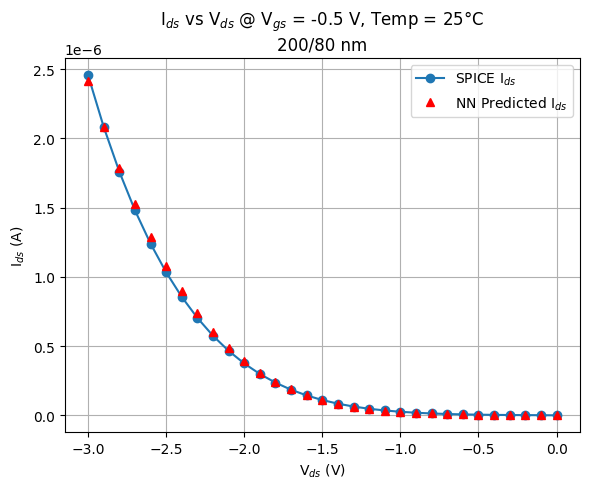

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


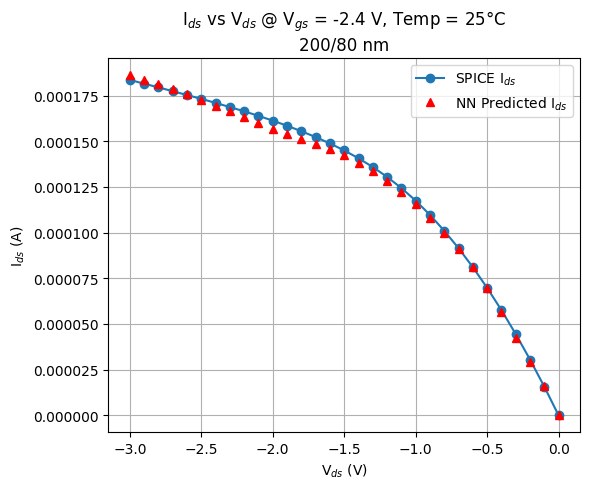

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


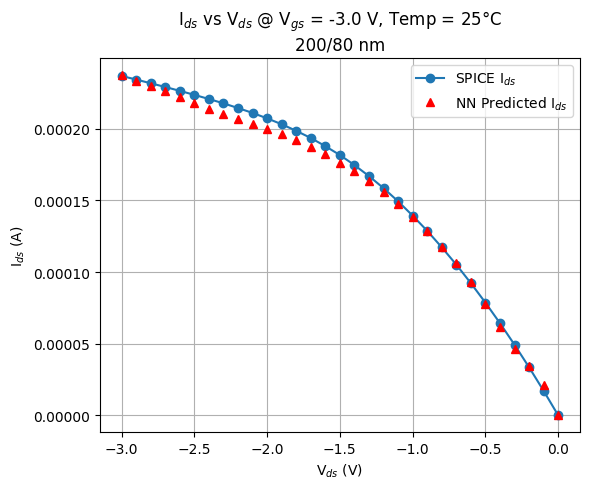

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


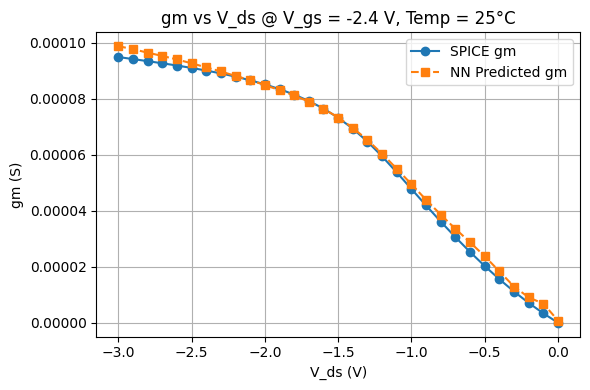

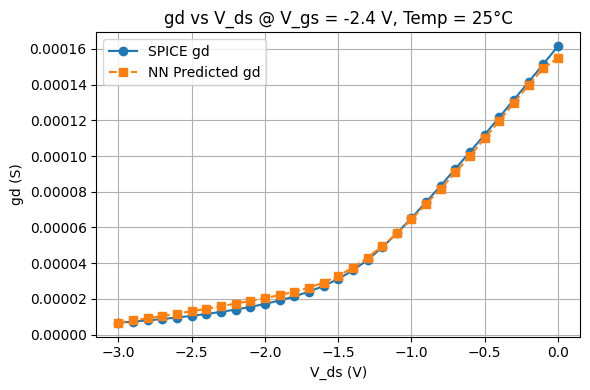

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


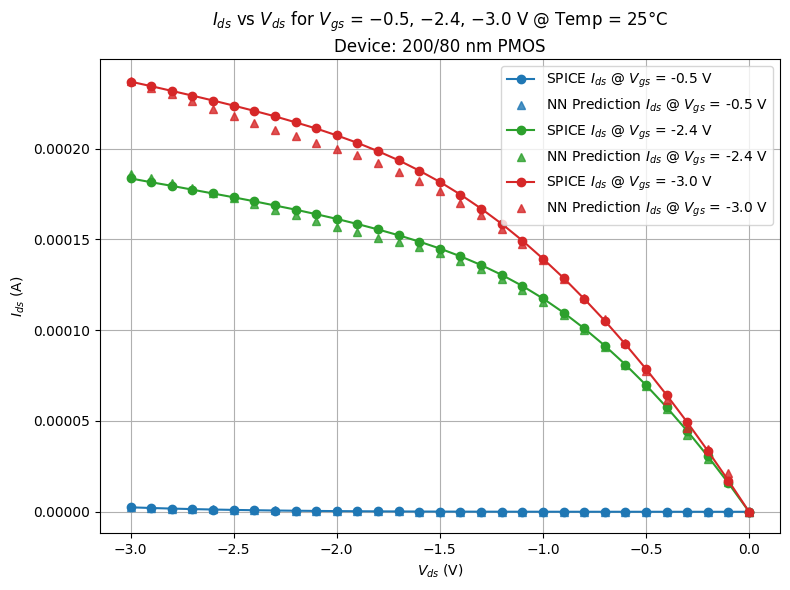

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


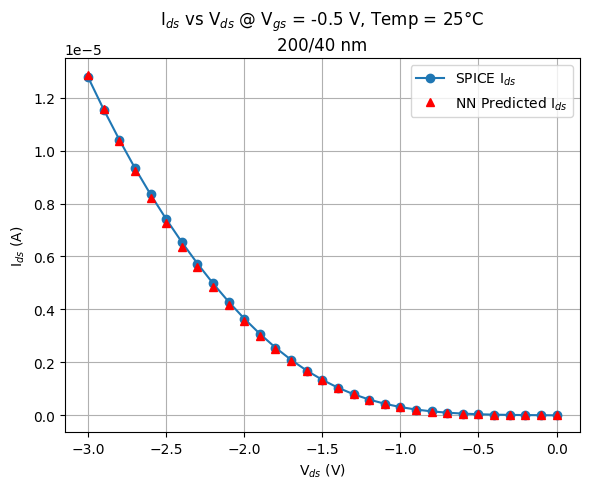

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


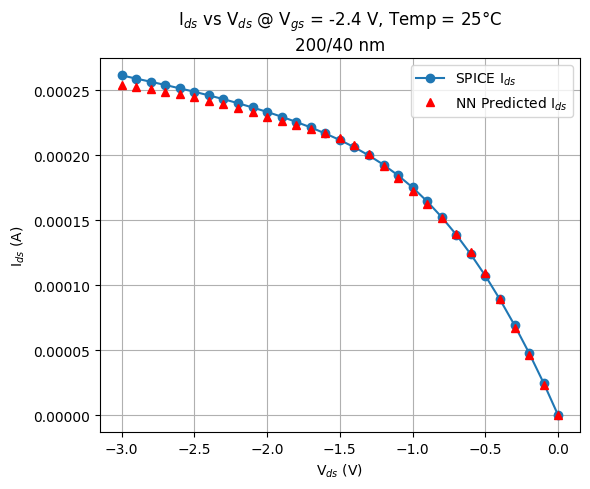

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


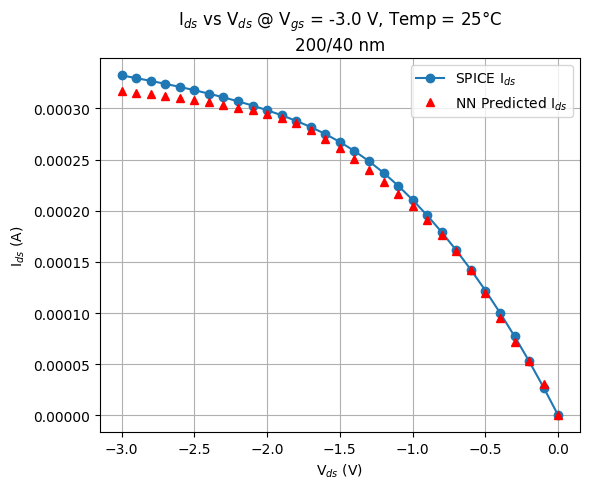

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


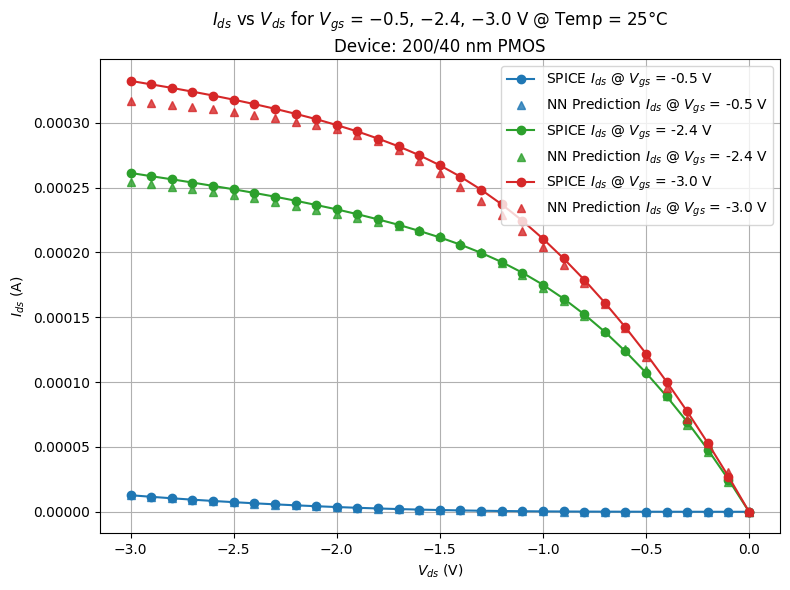

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


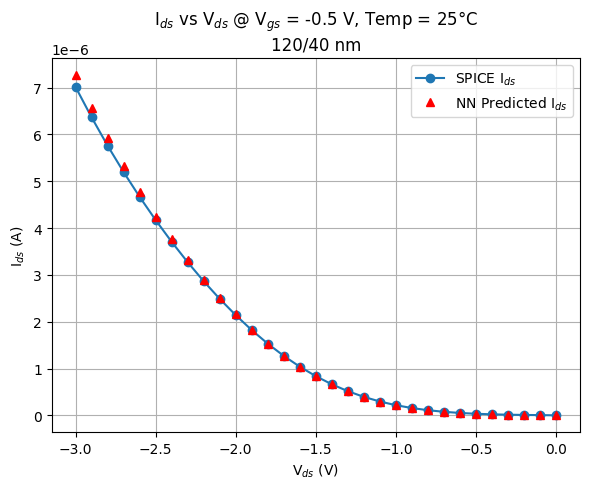

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


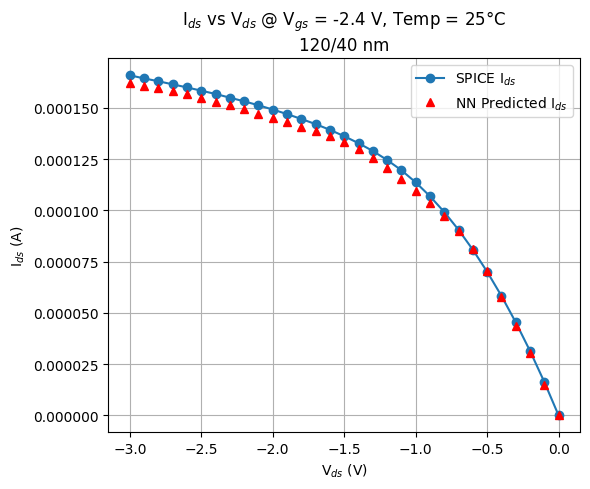

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


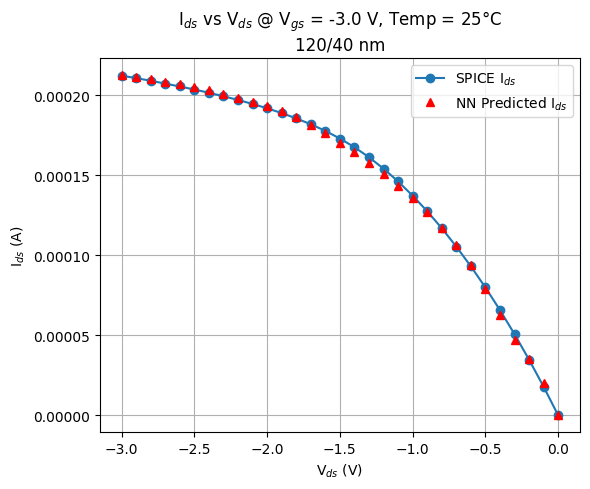

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


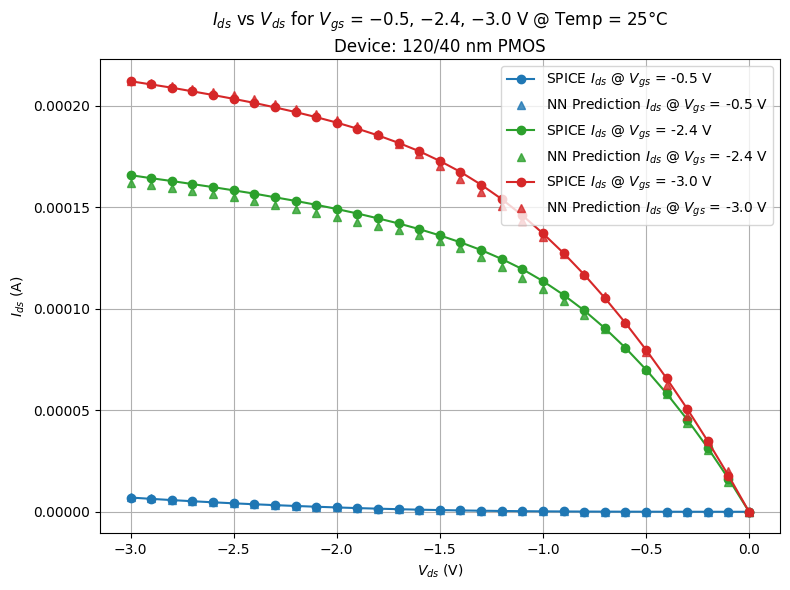

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


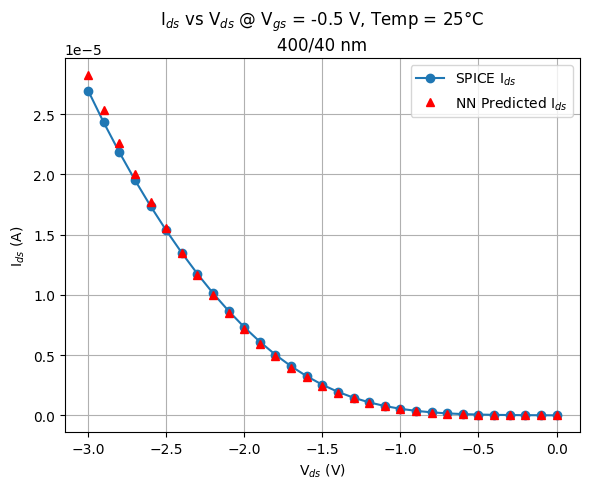

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


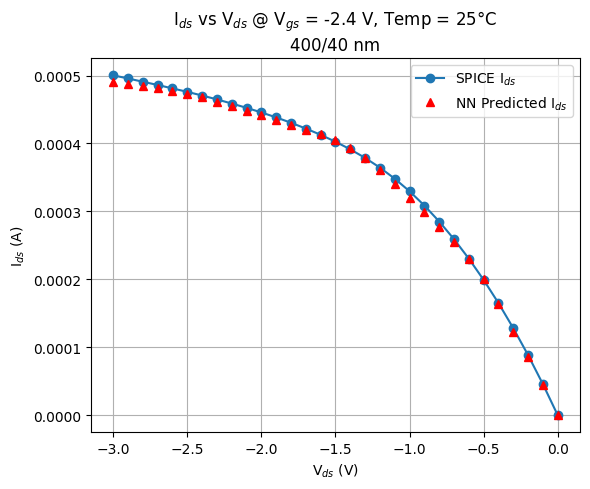

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


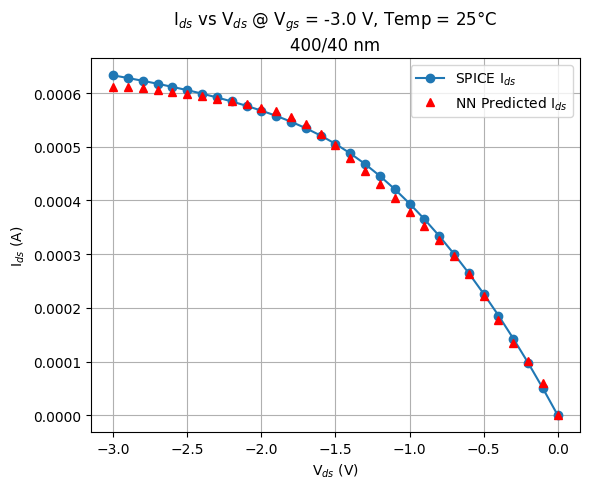

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


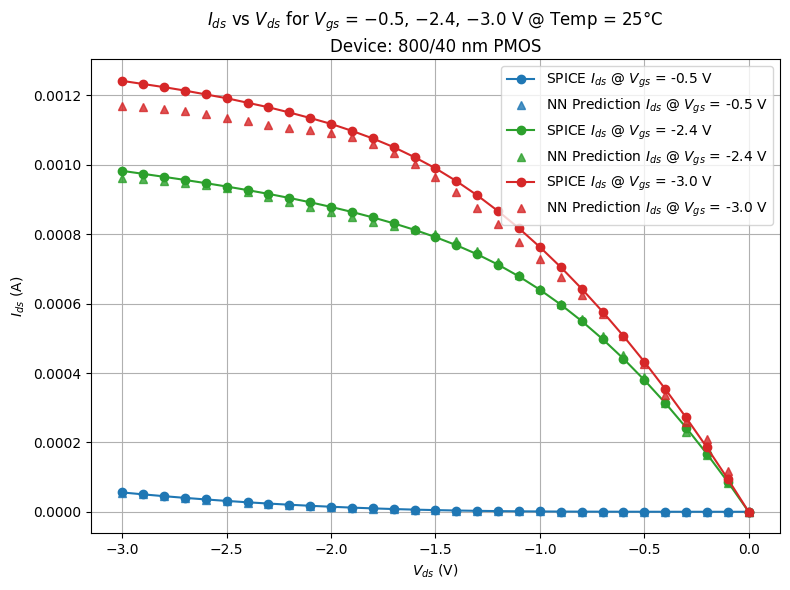

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


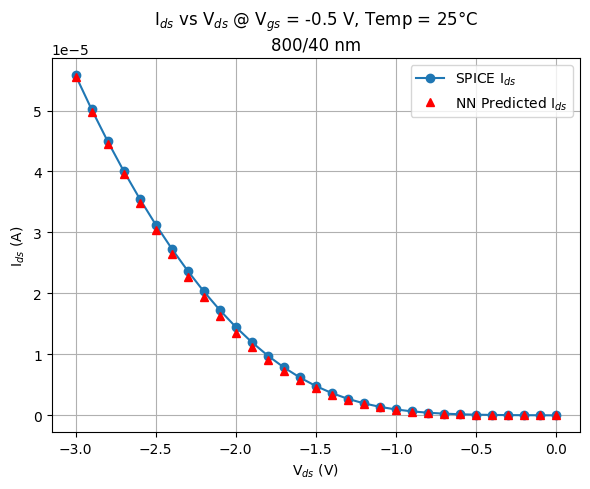

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


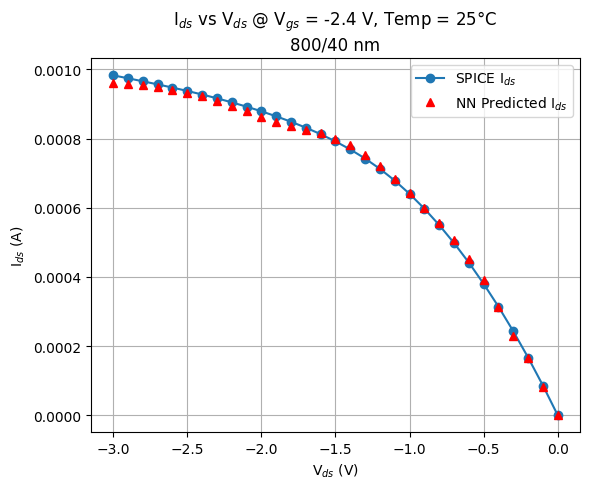

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


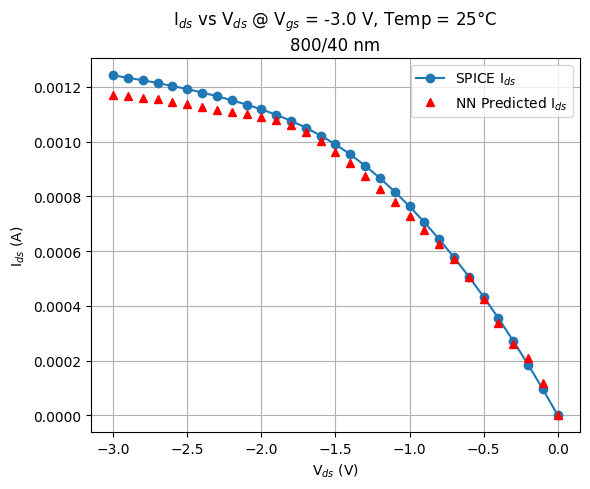

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


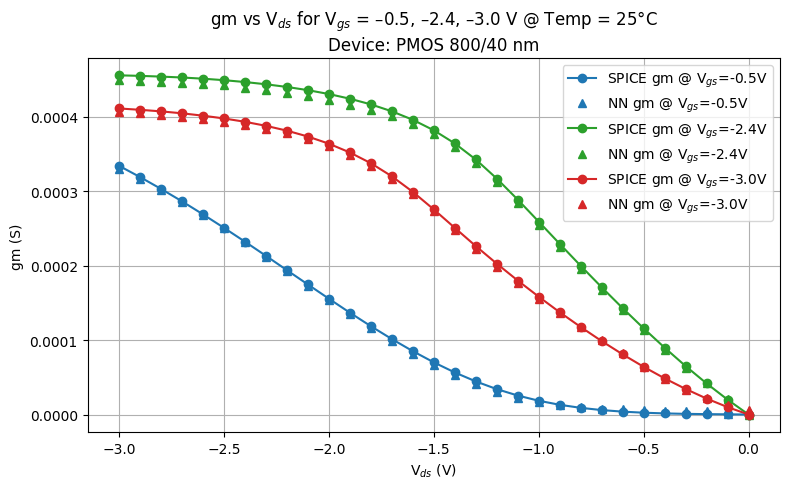

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<Figure size 800x500 with 0 Axes>

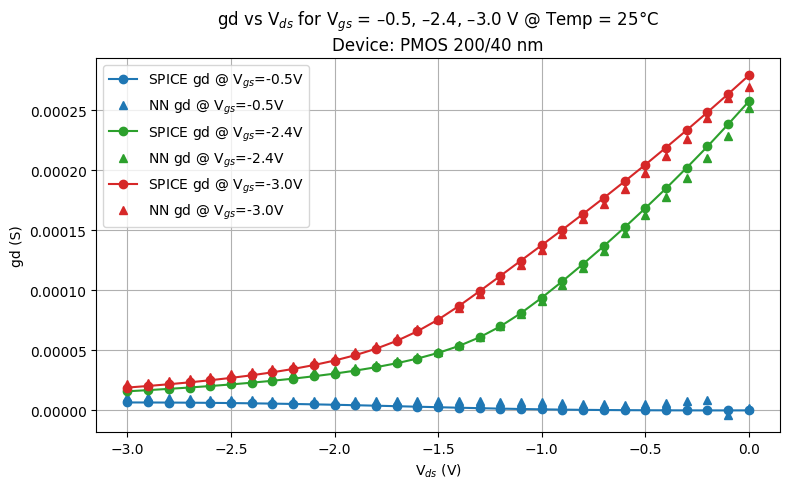

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<Figure size 800x500 with 0 Axes>

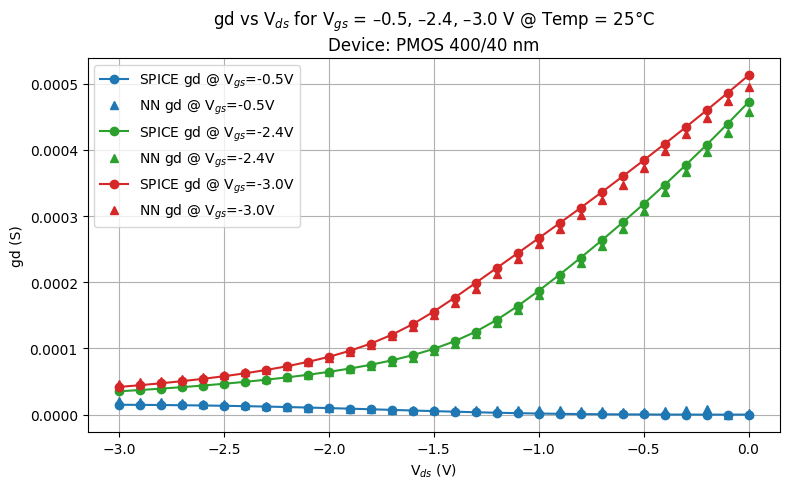

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<Figure size 800x500 with 0 Axes>

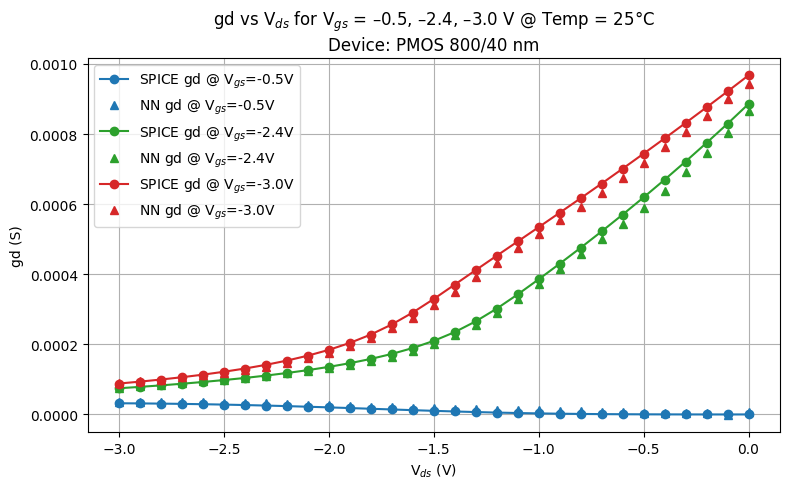

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


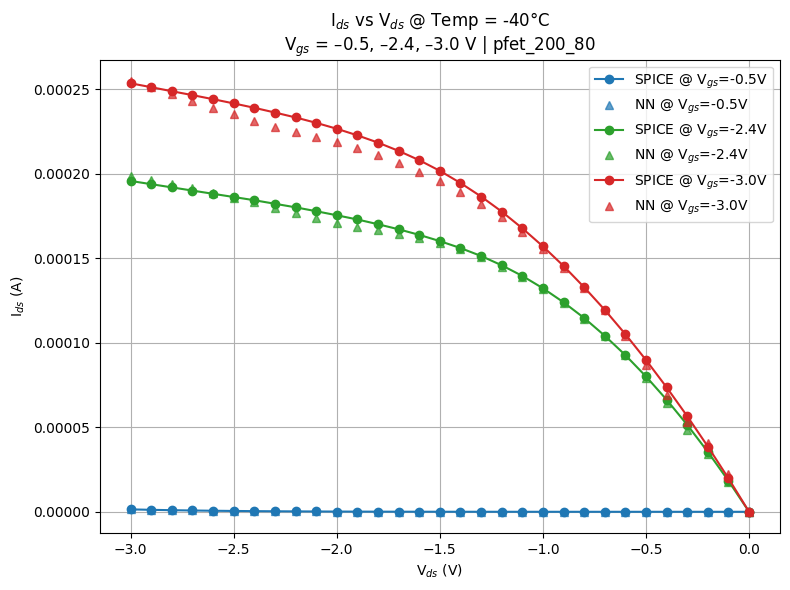

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


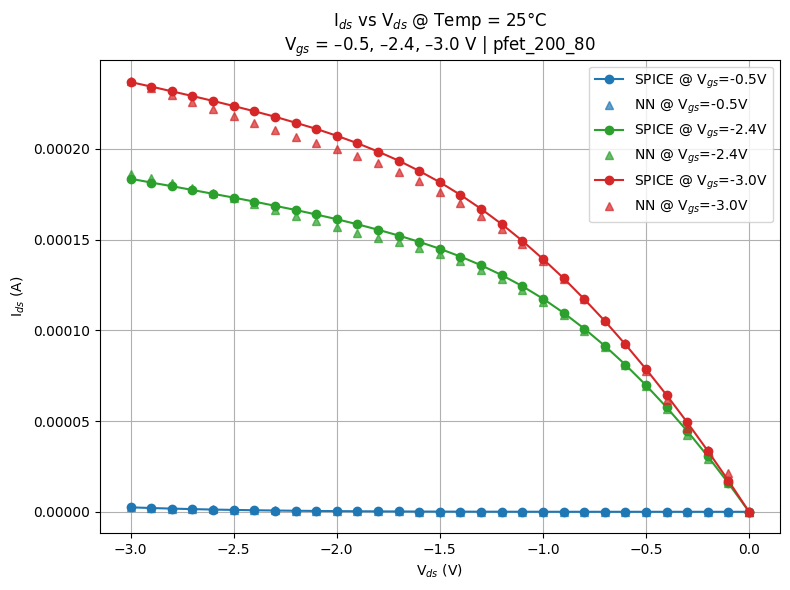

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


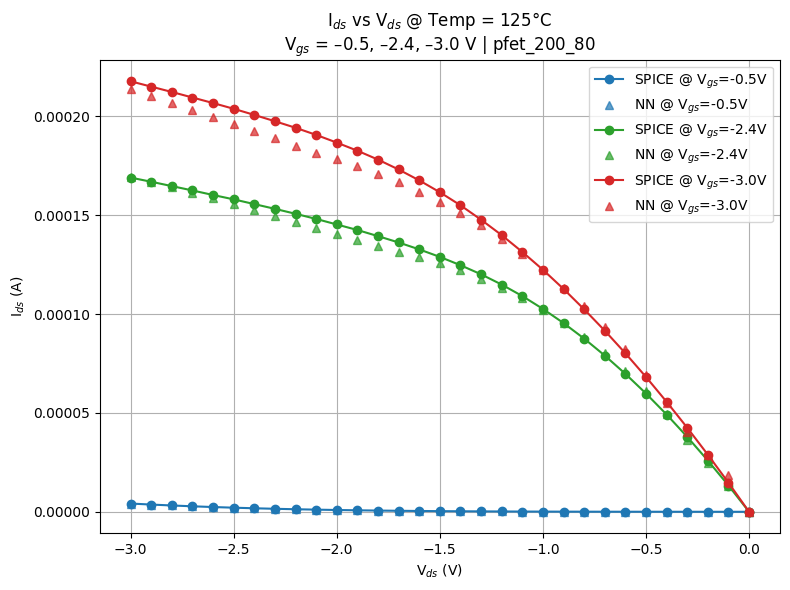

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


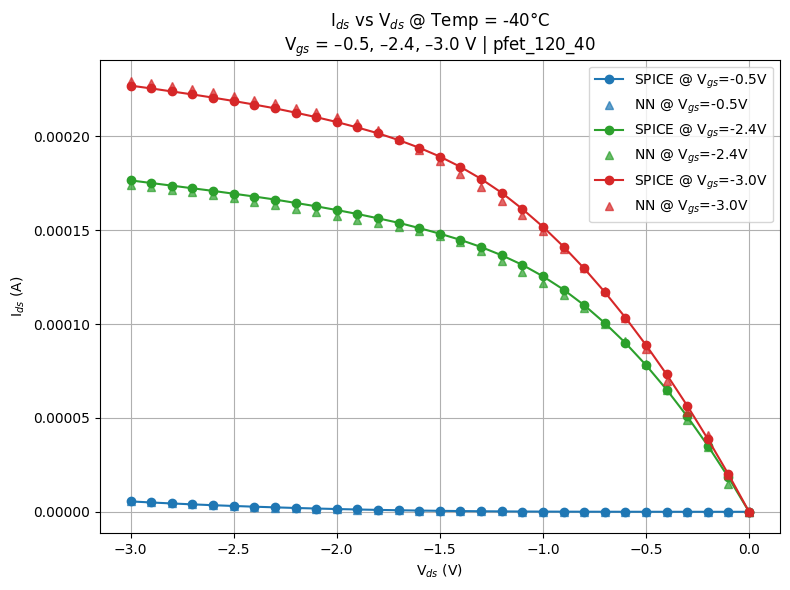

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


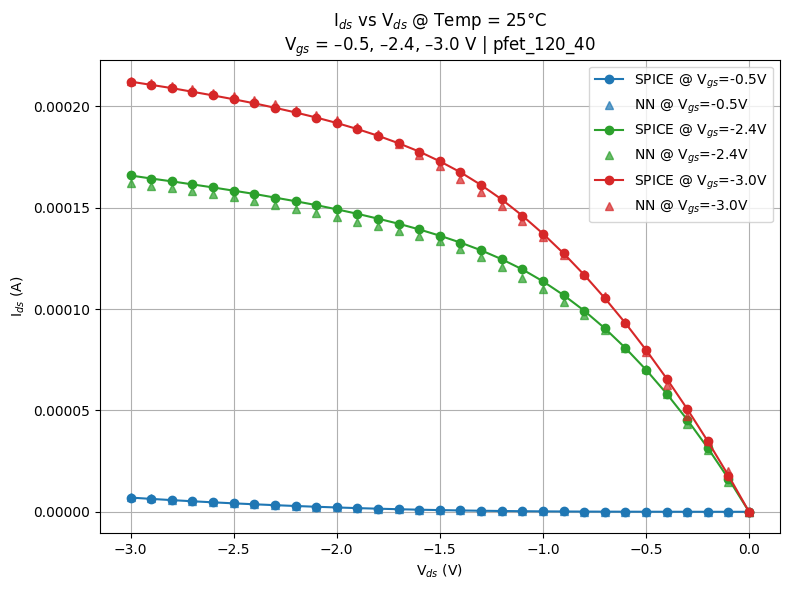

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


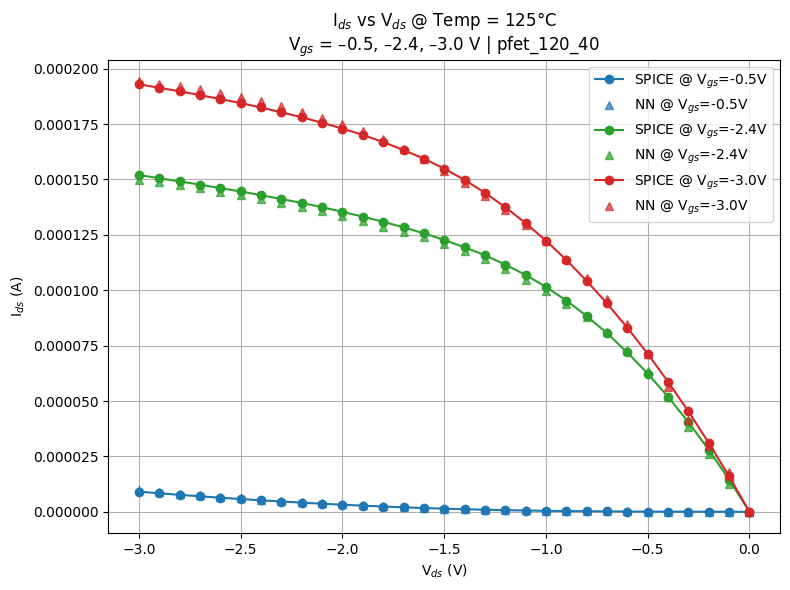

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


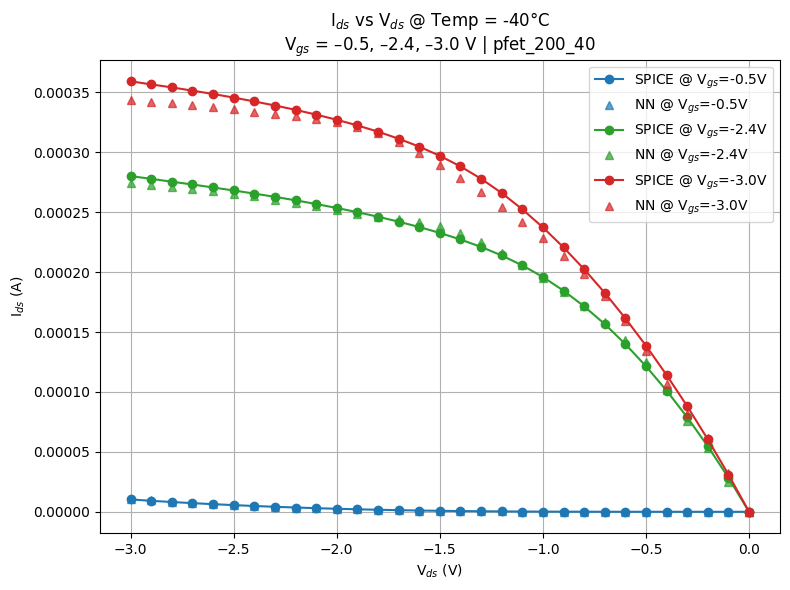

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


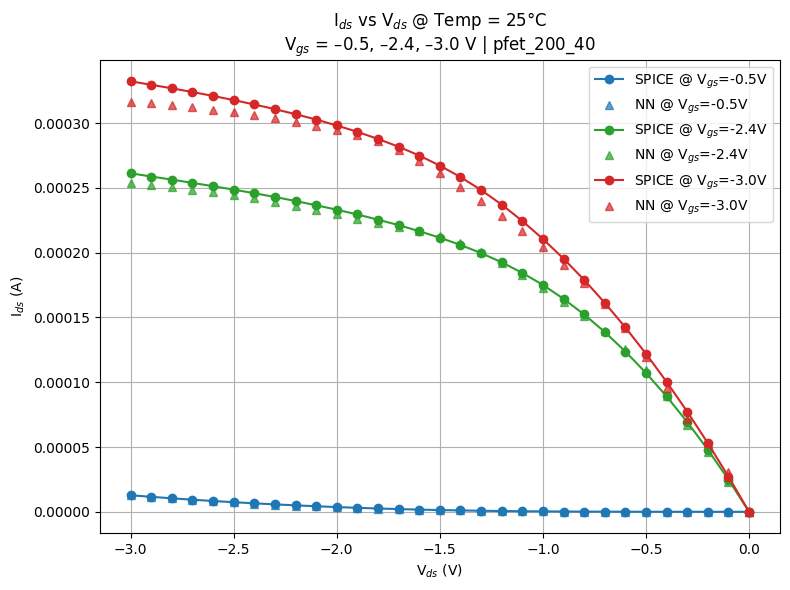

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


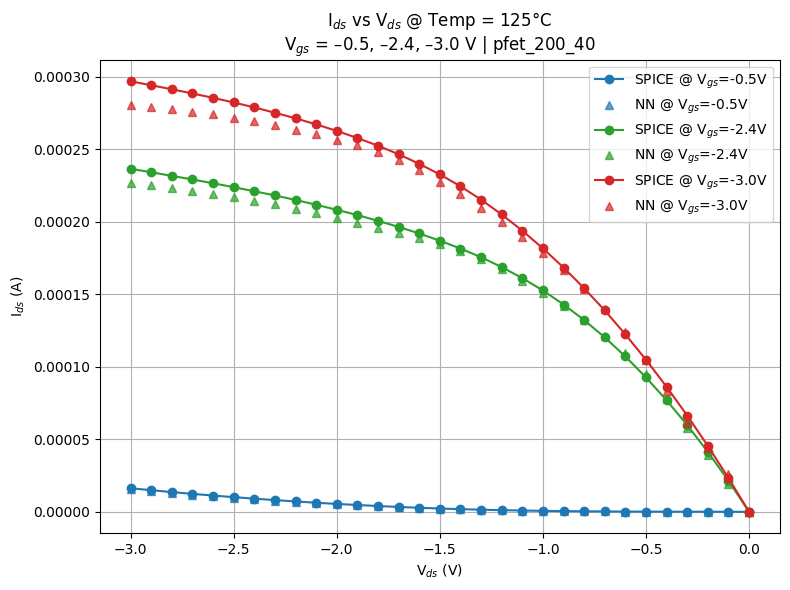

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


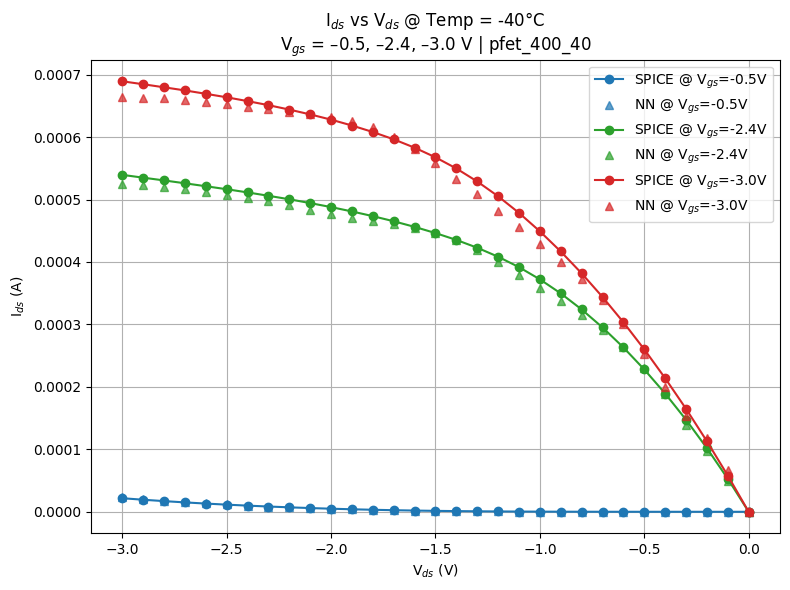

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


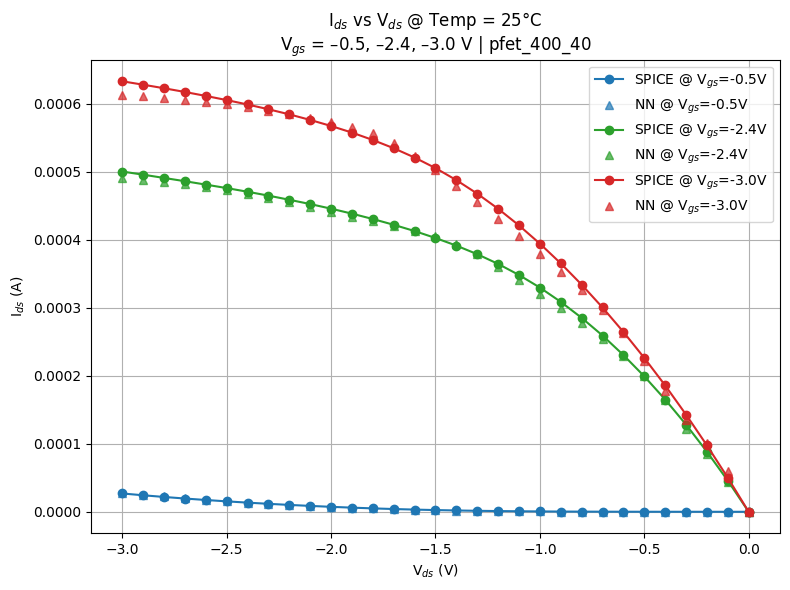

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


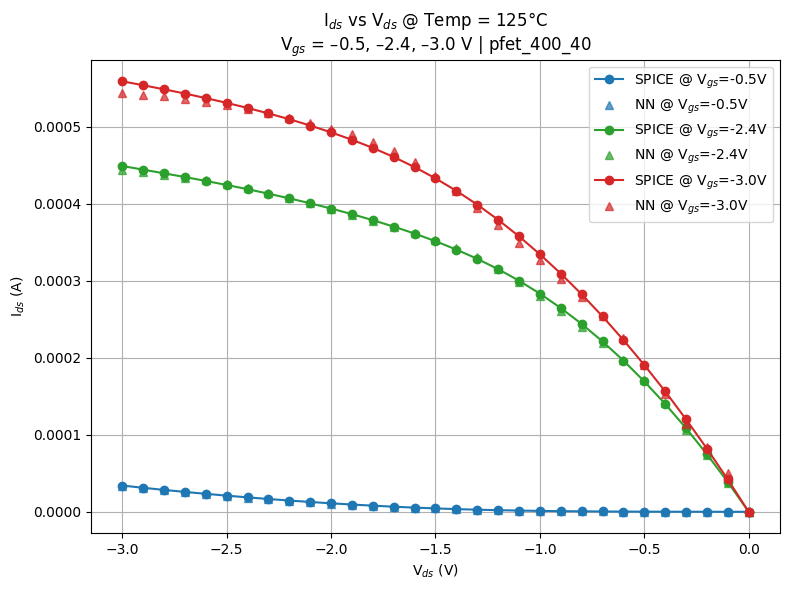

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


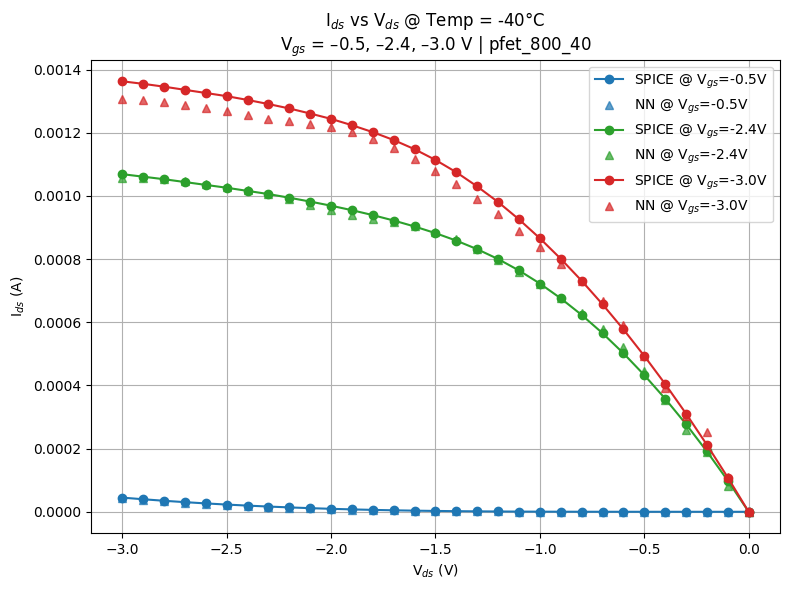

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


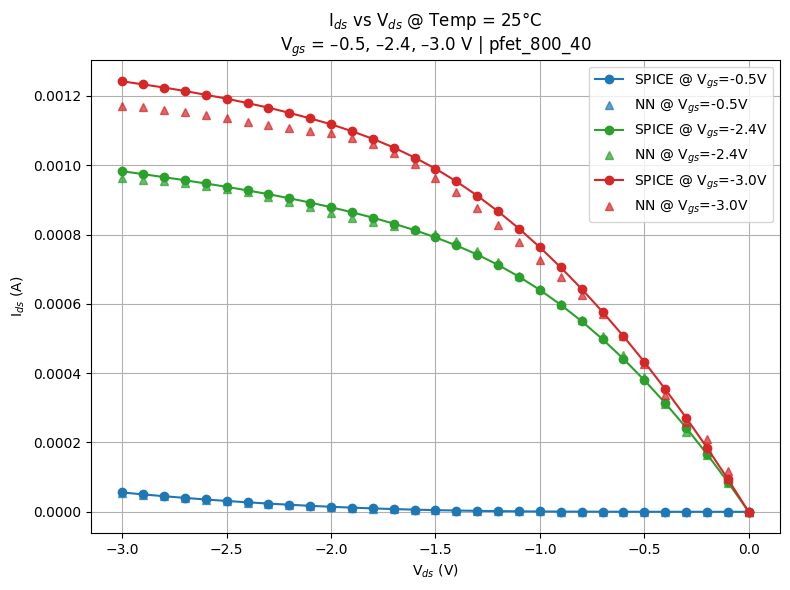

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


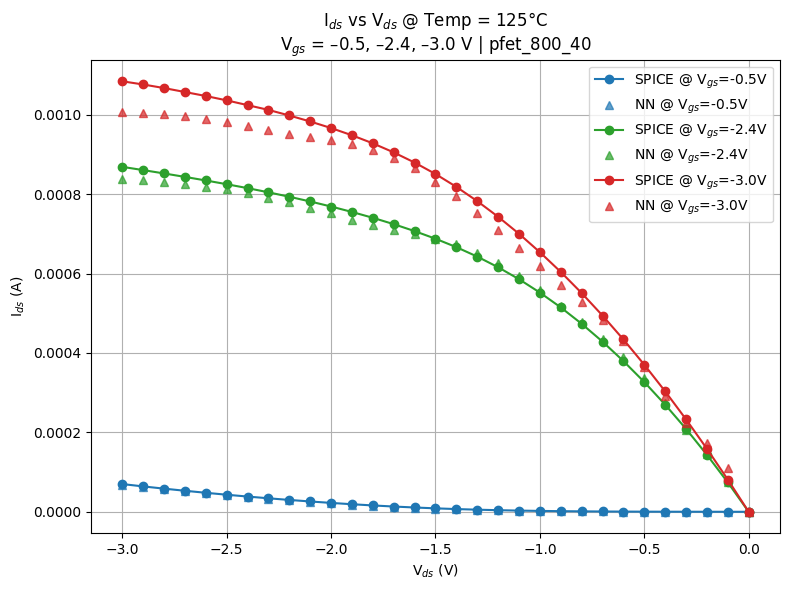

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


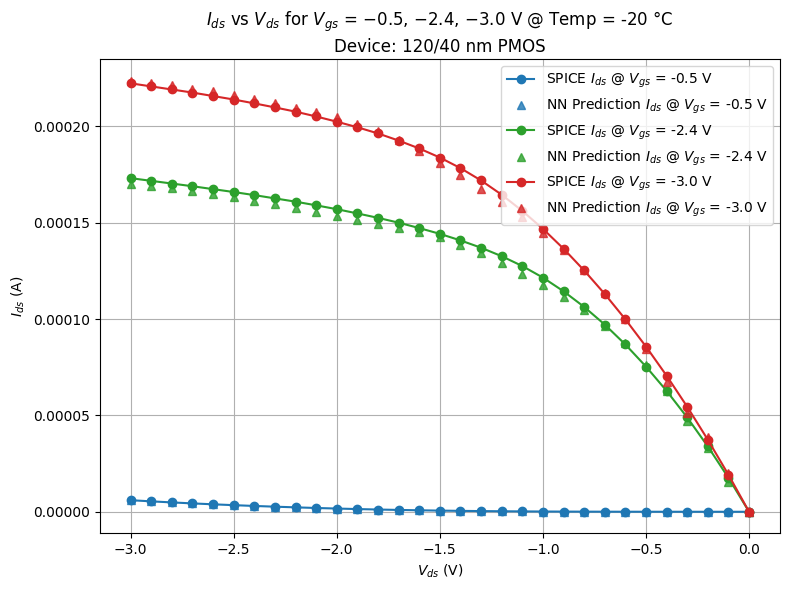

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


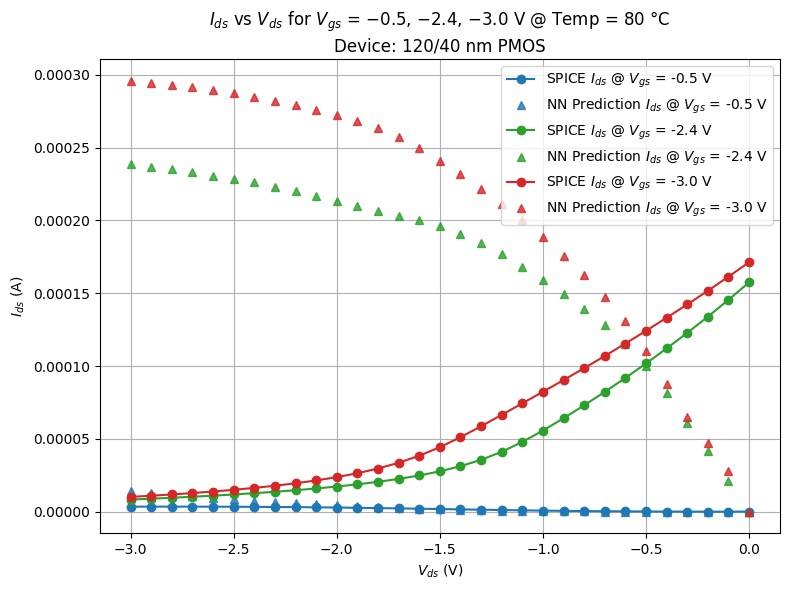

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


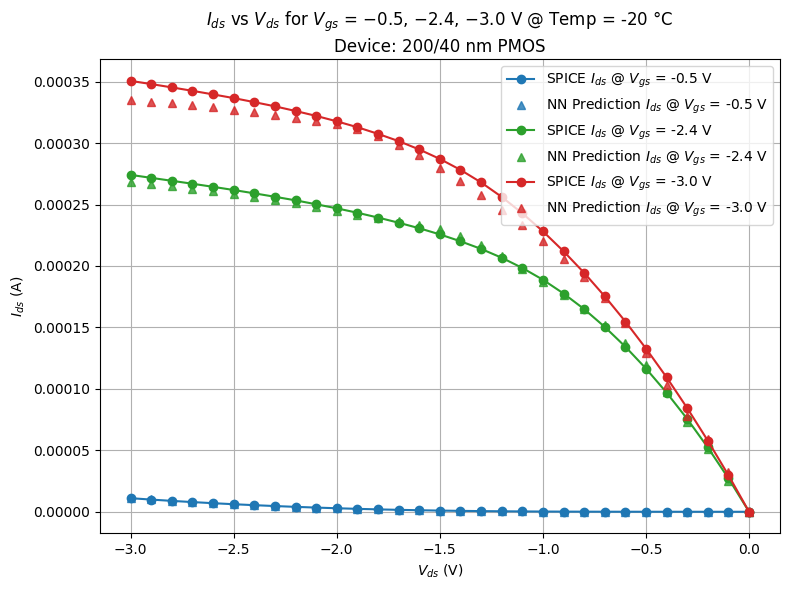

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


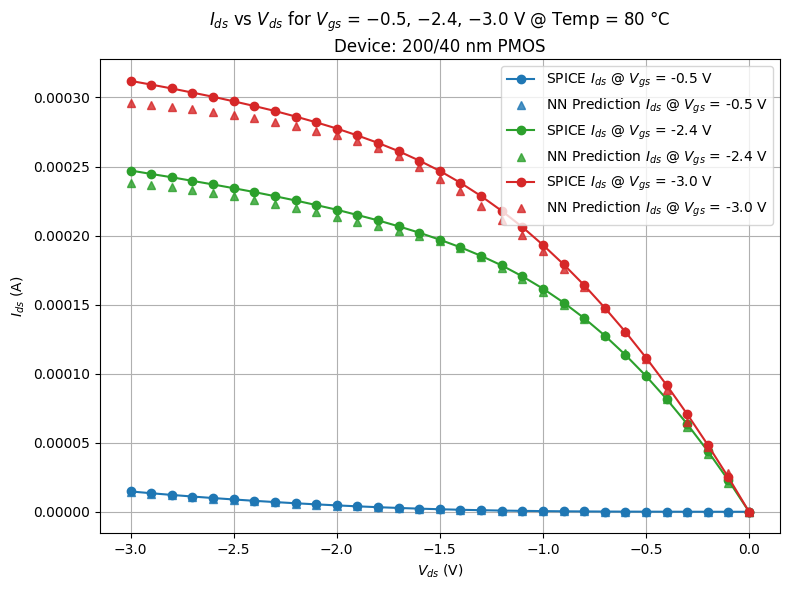

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


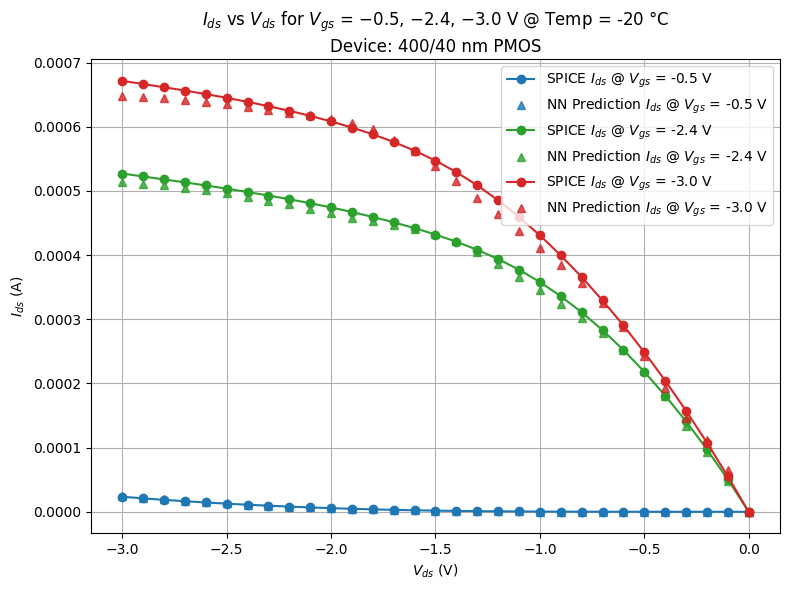

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


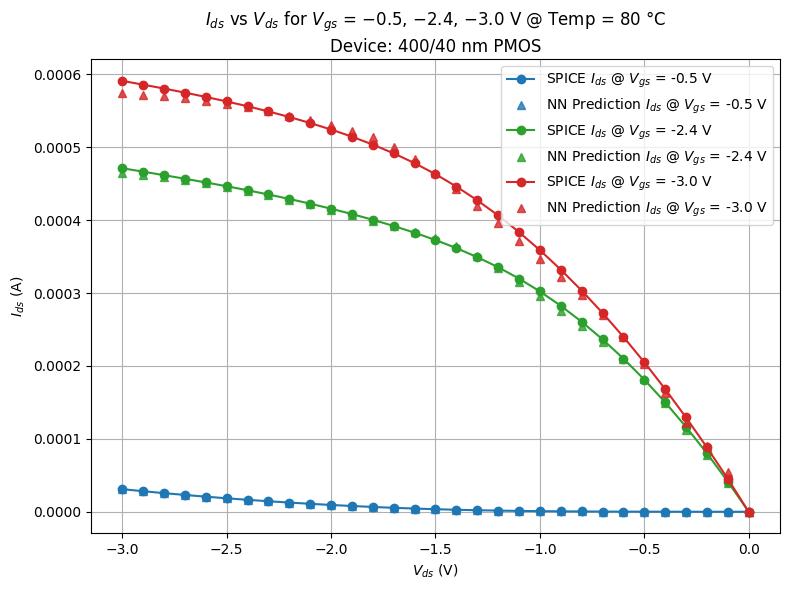

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


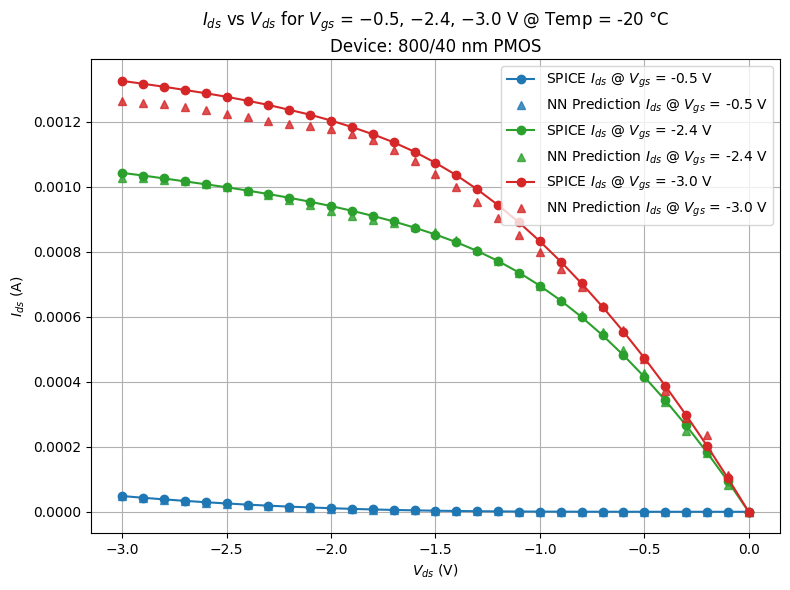

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


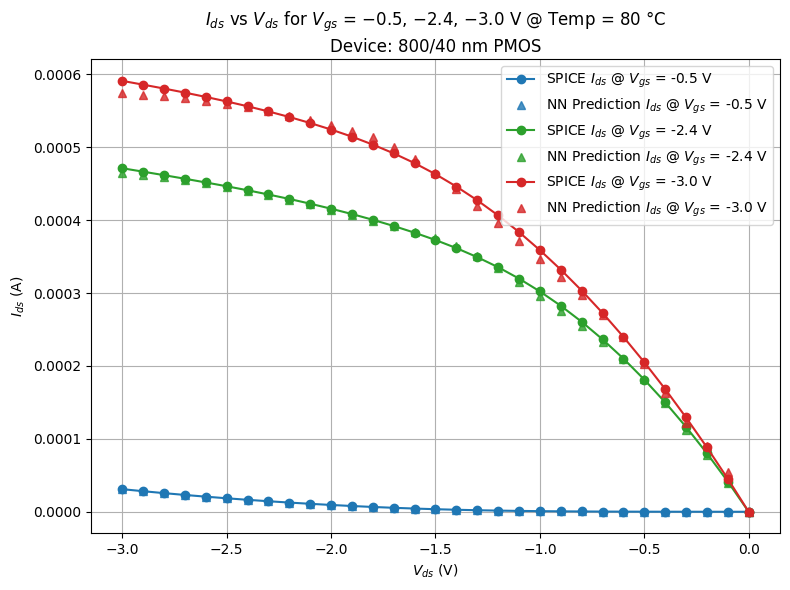

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
